### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import glob
from oak_cli.evaluation.resources.main import ResourcesCSVKeys
from oak_cli.evaluation.addons.flops.main import FLOpsExclusiveCSVKeys, EvaluationRunFLOpsProjectStage, TRAINED_MODEL_PERFORMANCE_CSV, FLOpsTrainedModelCSVKeys
from oak_cli.evaluation.common import get_csv_dir_for_scenario
from oak_cli.evaluation.types import EvaluationScenario
from oak_cli.evaluation.graph_utils import get_evaluation_run_duration_label, adjust_xticks
from typing import List, Callable, Optional, Tuple
from pydantic import BaseModel
import pathlib
from oak_cli.utils.logging import logger
from icecream import ic
from matplotlib.patches import Patch

### Settings

In [2]:
USE_MINUTES = True

### Constants

In [3]:
#csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)

csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_mnist_sklearn_small_without_baseimages")

### Auxiliary Constants

In [4]:
CPU_KEY = ResourcesCSVKeys.CPU_USAGE.value
MEMORY_KEY = ResourcesCSVKeys.MEMORY_USAGE.value
TIME_START_KEY = ResourcesCSVKeys.TIME_SINCE_START.value
RUN_ID_KEY = ResourcesCSVKeys.EVALUATION_RUN_ID.value
STAGE_KEY = FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value
DISK_START_KEY = ResourcesCSVKeys.DISK_SPACE_CHANGE_SINCE_START.value

NUMBER_OF_TOTAL_STAGES = len(list(EvaluationRunFLOpsProjectStage))

### Data Loading

In [5]:
csv_files = glob.glob(f'{csv_dir}/evaluation_run_*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

trained_model_df = pd.read_csv(TRAINED_MODEL_PERFORMANCE_CSV)

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[TIME_START_KEY]] = df[[TIME_START_KEY]].astype(int)

df.set_index(TIME_START_KEY, inplace=True)

if USE_MINUTES:
    df.index = df.index / 60

singular_run_df = df[df[RUN_ID_KEY] == (df[RUN_ID_KEY].max() // 2)]

### Auxiliary Logic


In [6]:
class _Stage_Info(BaseModel):
    stage: EvaluationRunFLOpsProjectStage
    start: float = 0
    end: float = 0


def _draw_stages(data: pd.DataFrame, color_intensity: float) -> None:
    stages: List[_Stage_Info] = []
    last_stage = ""
    for index, row in data.iterrows():
        current_stage = EvaluationRunFLOpsProjectStage(row[STAGE_KEY])

        if last_stage == "":
            last_stage = current_stage
            stages.append(_Stage_Info(start=0, stage=current_stage))

        if last_stage != current_stage:
            last_stage = current_stage
            plt.axvline(x=index, color='grey', linestyle='--', ymax=100)
            _last_stage = stages[-1]
            _last_stage.end = float(index)
            next_stage = _Stage_Info(start=index, stage=current_stage)
            stages.append(next_stage)

    stages[-1].end = max(data.index)
    for stage_info in stages:
        plt.fill_between(
            (stage_info.start,stage_info.end),
            100,
            color=sns.color_palette(
                palette="tab10",
                n_colors=NUMBER_OF_TOTAL_STAGES,
            )[stage_info.stage.get_index()],
            alpha=color_intensity,
        )

    original_handles, original_labels = plt.gca().get_legend_handles_labels()
    # Create a patch for each stage/color combination
    stage_names =  [stage.value for stage in EvaluationRunFLOpsProjectStage]
    color_palette = sns.color_palette("tab10", n_colors=NUMBER_OF_TOTAL_STAGES)

    stages_of_current_data = data[STAGE_KEY].unique()
    new_patches = []
    for stage_name, color in zip(stage_names, color_palette):
        if stage_name not in stages_of_current_data:
            continue
        new_patches.append(
            Patch(
                facecolor=color,
                edgecolor='black',
                label=stage_name,
                alpha=color_intensity,
            )
        )

    combined_handles = original_handles + [patch for patch in new_patches]  # Directly use Patch objects as handles
    combined_labels = original_labels + [patch.get_label() for patch in new_patches]  # Retrieve labels from Patch objects
    # Add the unified legend to the plot
    plt.gca().legend(
        handles=combined_handles,
        labels=combined_labels,
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )


def draw_graph(
        title: Optional[str] = "",
        plot_functions: Optional[List[Callable]] = None,
        data: Optional[pd.DataFrame] = None,
        x_lim: Optional[Tuple[float, float]] = None,
        y_lim: Optional[Tuple[float, float]] = None,
        y_label: str = "Resource Usage (%)",
        size: Tuple[int,int] = (10, 5),
        show_stages: bool = False,
        stages_color_intensity: float = 0.3,
        use_percentage_limits: bool = False,
    ) -> None:
    fig, ax = plt.subplots(figsize=size)
    if title:
        ax.set_title(title)

    if not plot_functions:
        sns.lineplot(data=data)
    else:
        for plot_function in plot_functions:
            plot_function()
    plt.xlabel(get_evaluation_run_duration_label())
    plt.ylabel(y_label)
    adjust_xticks(ax)

    if use_percentage_limits:
        if not y_lim:
            y_lim = (0,100)
        if not x_lim:
            x_lim = (0, max(data.index))
    
    if x_lim:
        plt.xlim([x_lim[0], x_lim[1]])
    if y_lim:
        plt.ylim([y_lim[0], y_lim[1]])

    if show_stages:
        _draw_stages(
            data=data,
            color_intensity=stages_color_intensity
        )

    plt.show()

def draw_line_graph_with_all_runs(
    y_label: str,
    key: str,
    title: str = "All Evaluation Runs - Duration Diversity"
    ) -> None:
    draw_graph(
        title=title,
        y_label=y_label,
        size=(15, 8),
        data=df,
        plot_functions=[lambda: sns.lineplot(
            data=df,
            x=TIME_START_KEY,
            y=key,
            hue=RUN_ID_KEY,
        )],
        use_percentage_limits=True,
    )

def draw_box_violin_plot_for_each_stage(
        y_label: str,
        key: str,
        title: Optional[str] = "",
        y_lim: Optional[Tuple[float, float]] = None,
    ) -> None:
    draw_graph(
        title=title,
        y_label=y_label,
        size=(25, 10),
        data=df,
        plot_functions=[
            lambda: sns.violinplot(
                x=STAGE_KEY,
                y=key,
                data=df,
                hue=STAGE_KEY,
                alpha=0.3,
                palette=flops_palette,
            ),
            lambda: sns.boxplot(
                x=STAGE_KEY,
                y=key,
                data=df,
                hue=STAGE_KEY,
                palette=flops_palette,
            ),
        ],
        y_lim=y_lim,
    )


### Error Handing & Checking

In [7]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Common Graph Styling

In [8]:
sns.set_style("whitegrid")
flops_palette = "rainbow"

---

# Graphs Drawing

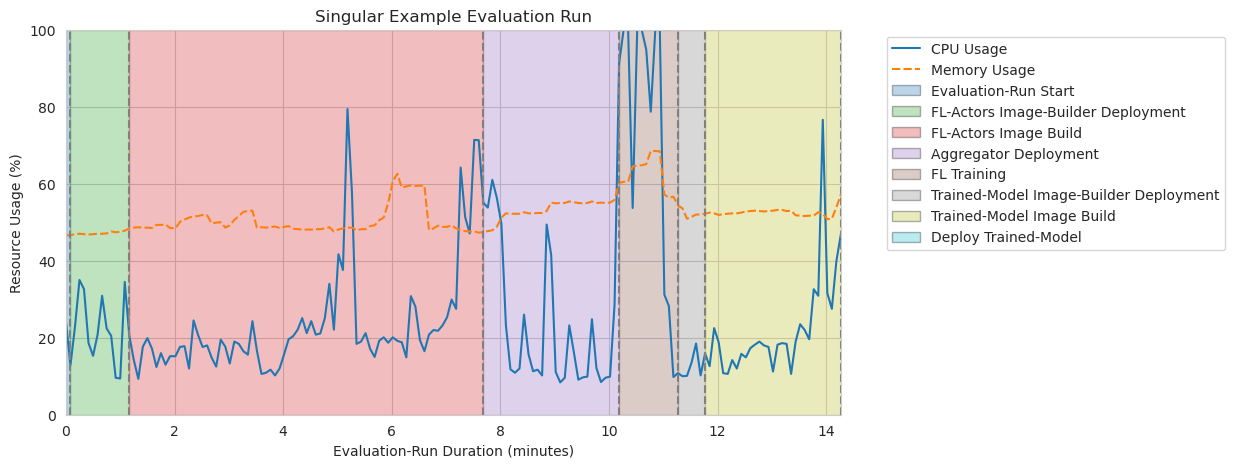

In [9]:
# CPU & Memory Usage of Single Evaluation Run
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    show_stages=True,
    use_percentage_limits=True,
)

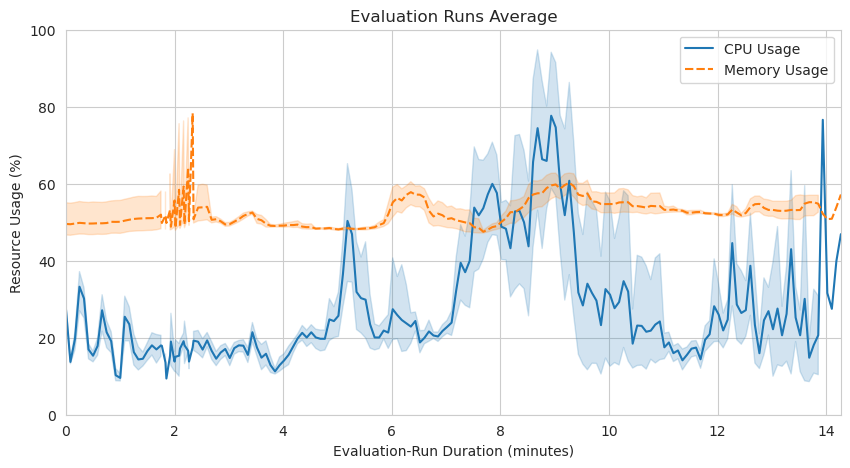

In [10]:
# CPU & Memory Usage of All/Average Evaluation Runs
draw_graph(
    title="Evaluation Runs Average",
    data=df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    use_percentage_limits=True,
    #show_stages=True,
    #stages_color_intensity=0.01,
)

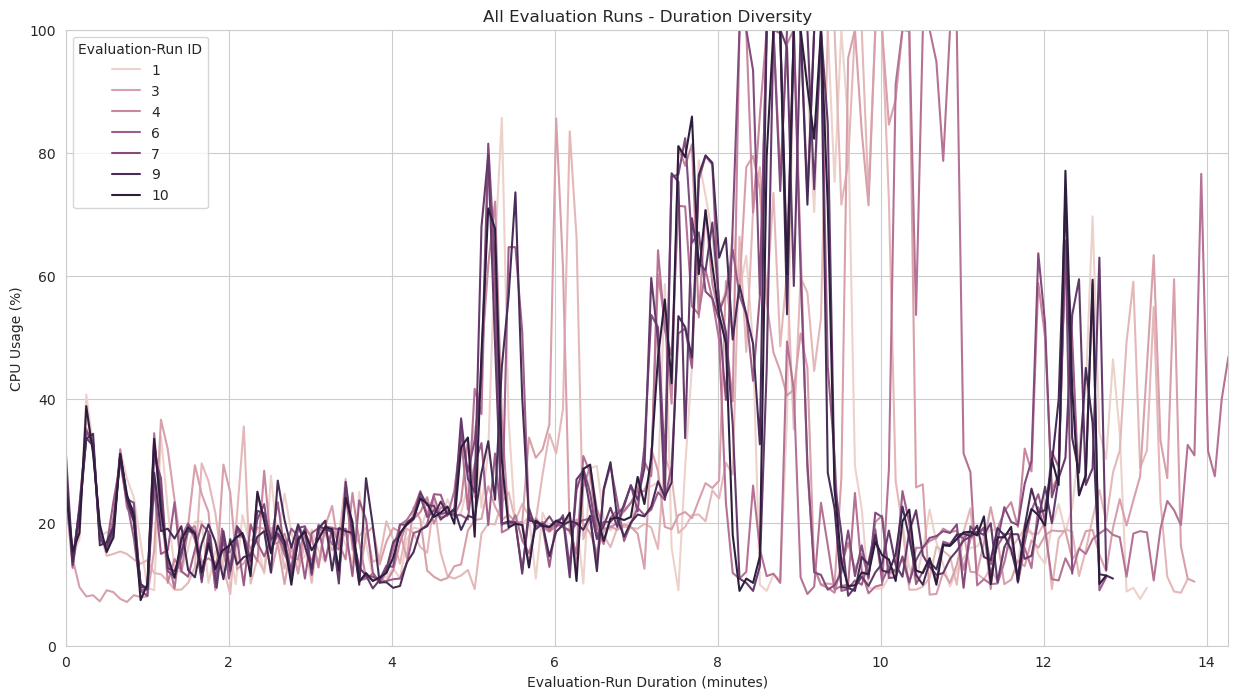

In [11]:
# CPU Usage of all Evaluation Runs
draw_line_graph_with_all_runs(
    y_label="CPU Usage (%)",
    key=CPU_KEY,
    )

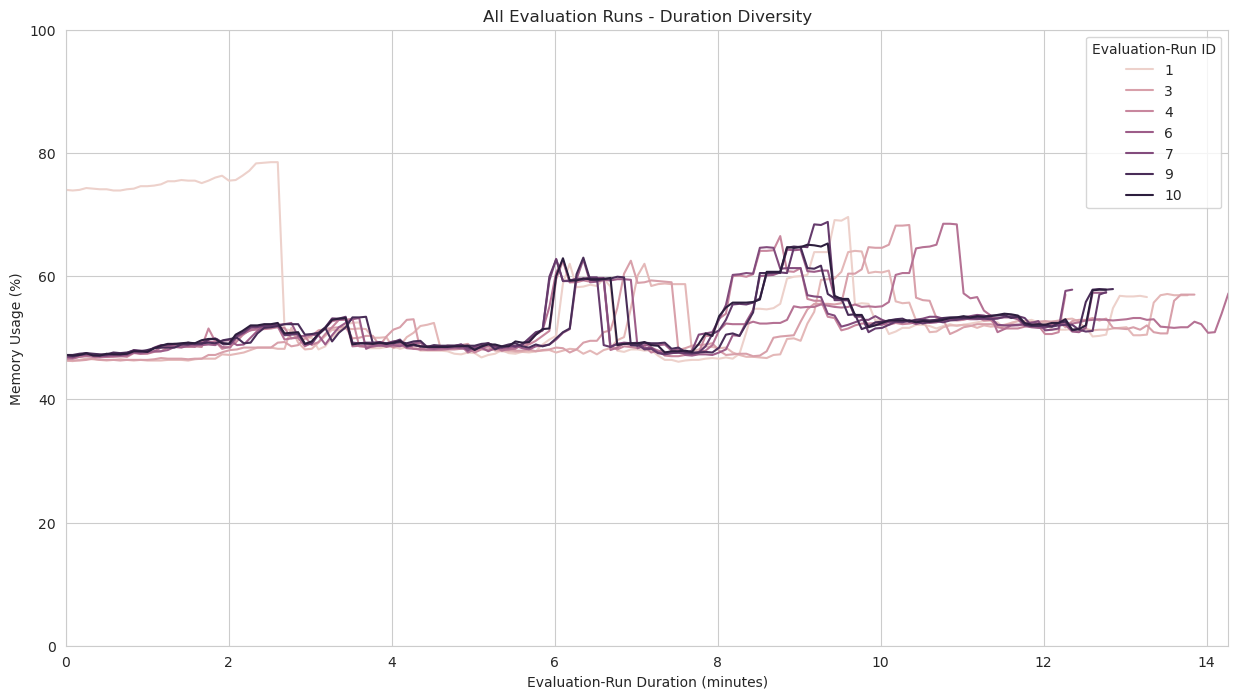

In [12]:
# Memory Usage of all Evaluation Runs
draw_line_graph_with_all_runs(
    y_label="Memory Usage (%)",
    key=MEMORY_KEY,
    )

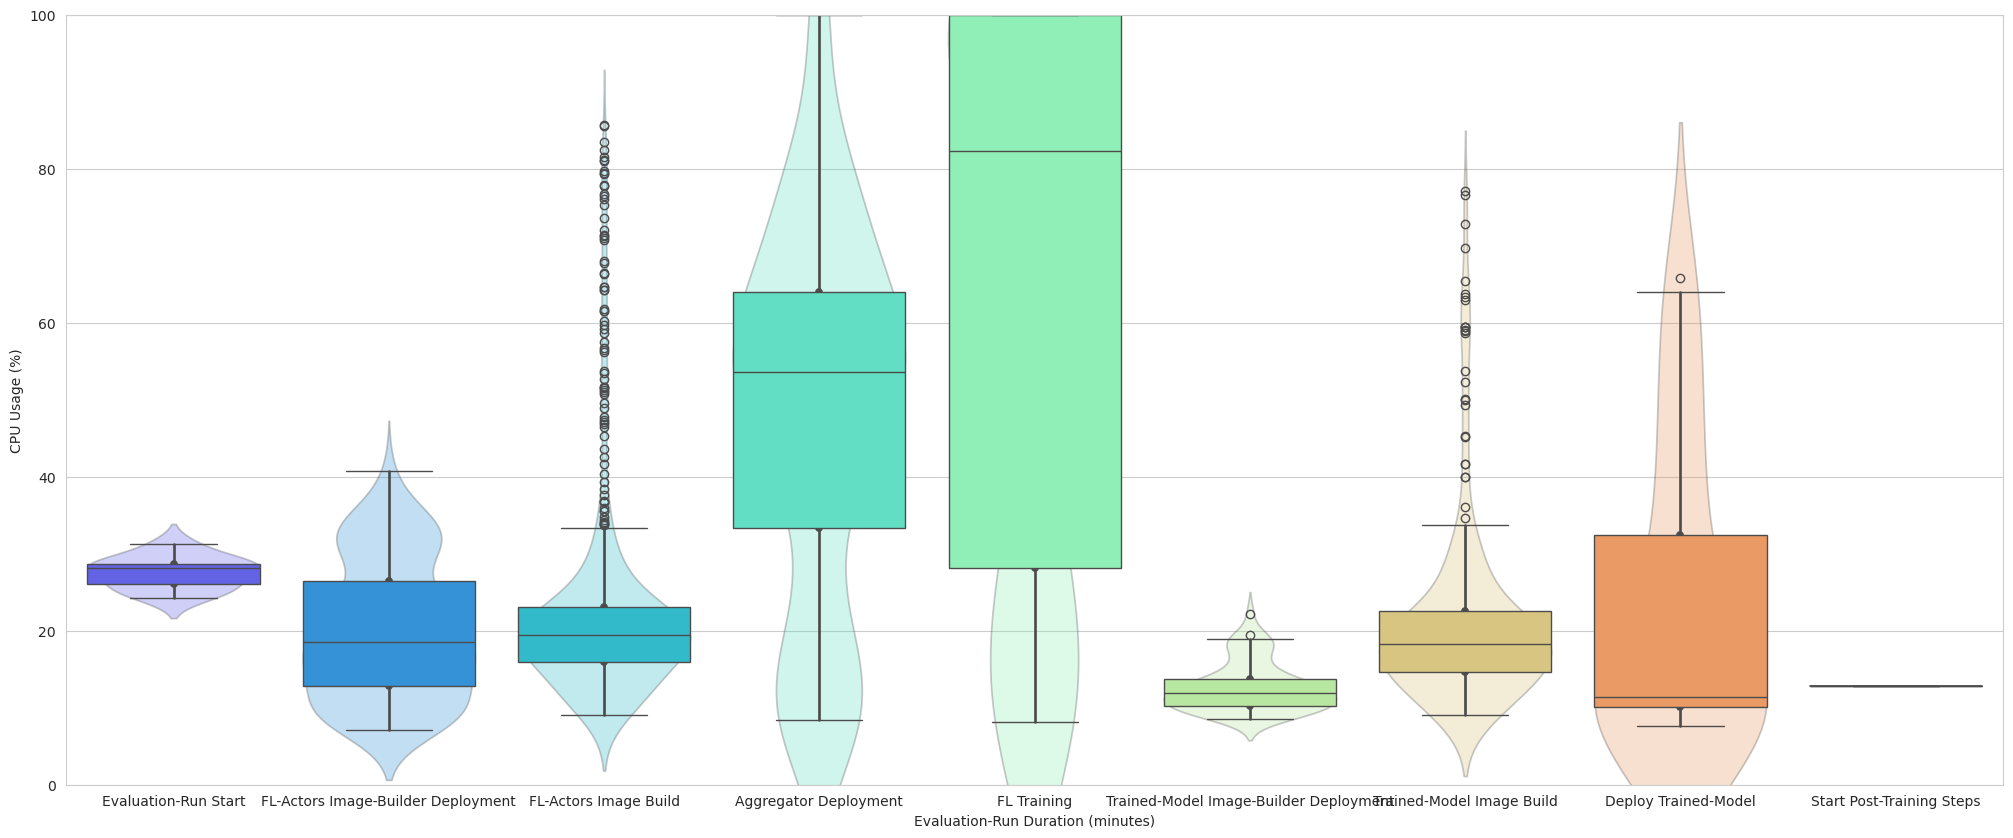

In [13]:
# CPU Usage per Stage
draw_box_violin_plot_for_each_stage(
    key=CPU_KEY,
    y_label="CPU Usage (%)",
    y_lim=(0,100)
)

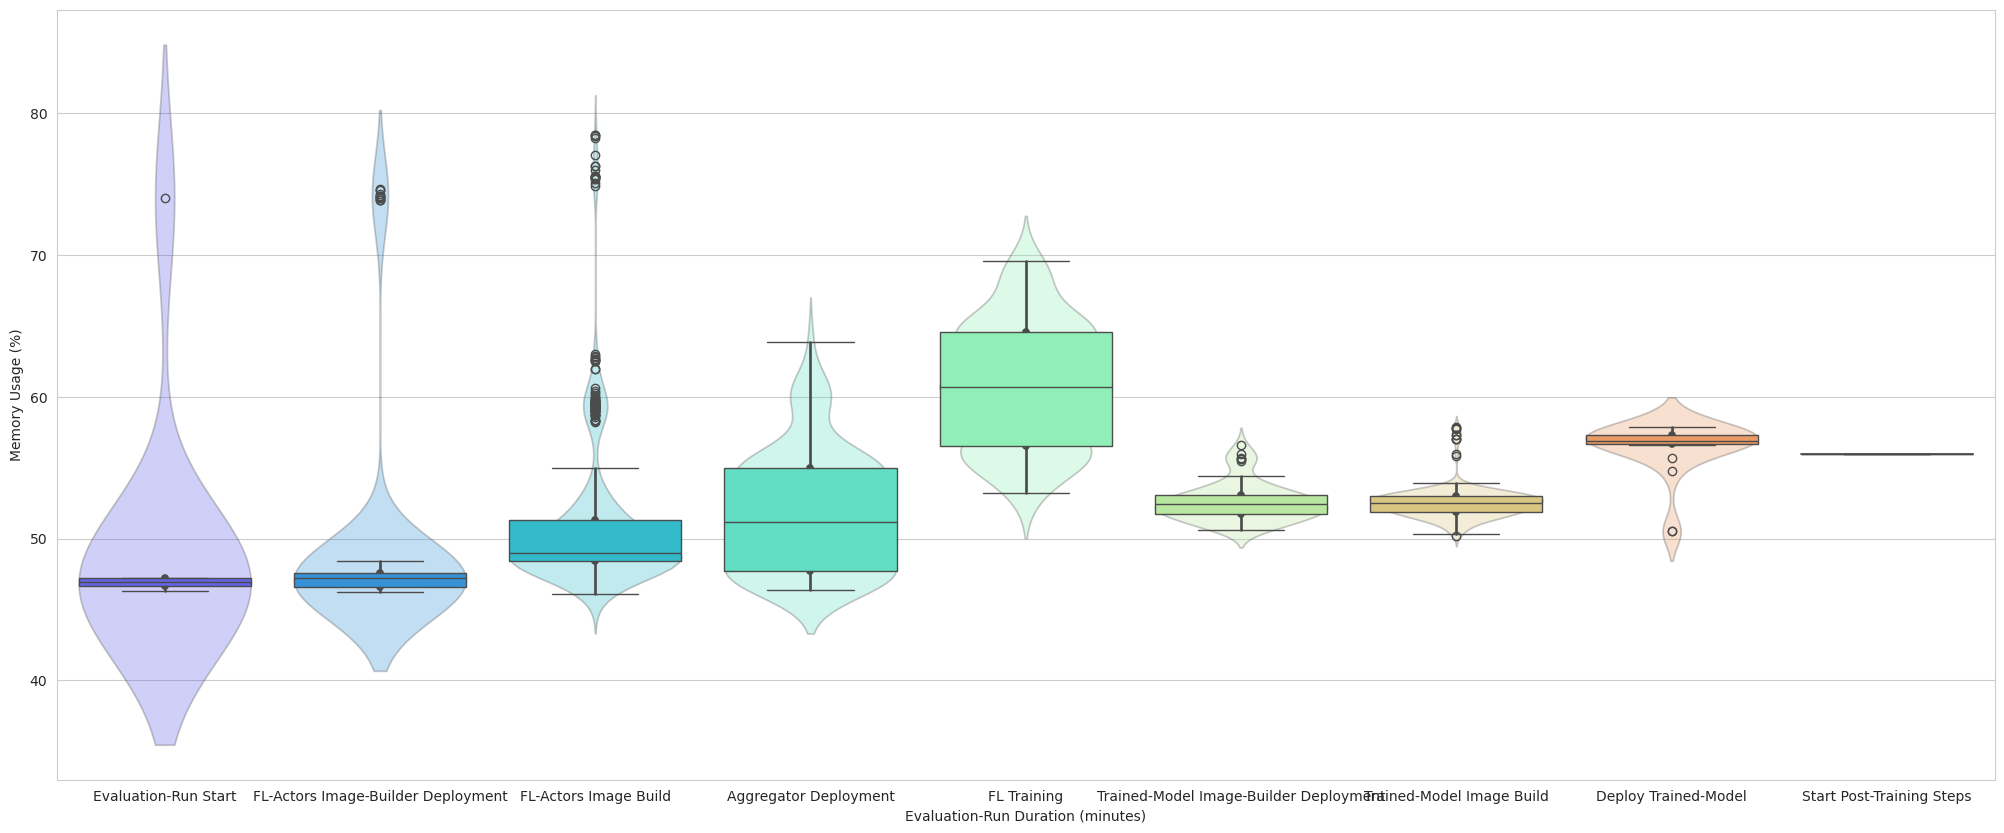

In [14]:
# CPU Usage per Stage
draw_box_violin_plot_for_each_stage(
    key=MEMORY_KEY,
    y_label="Memory Usage (%)",
)

/tmp/ipykernel_623944/670744908.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  lambda: sns.countplot(


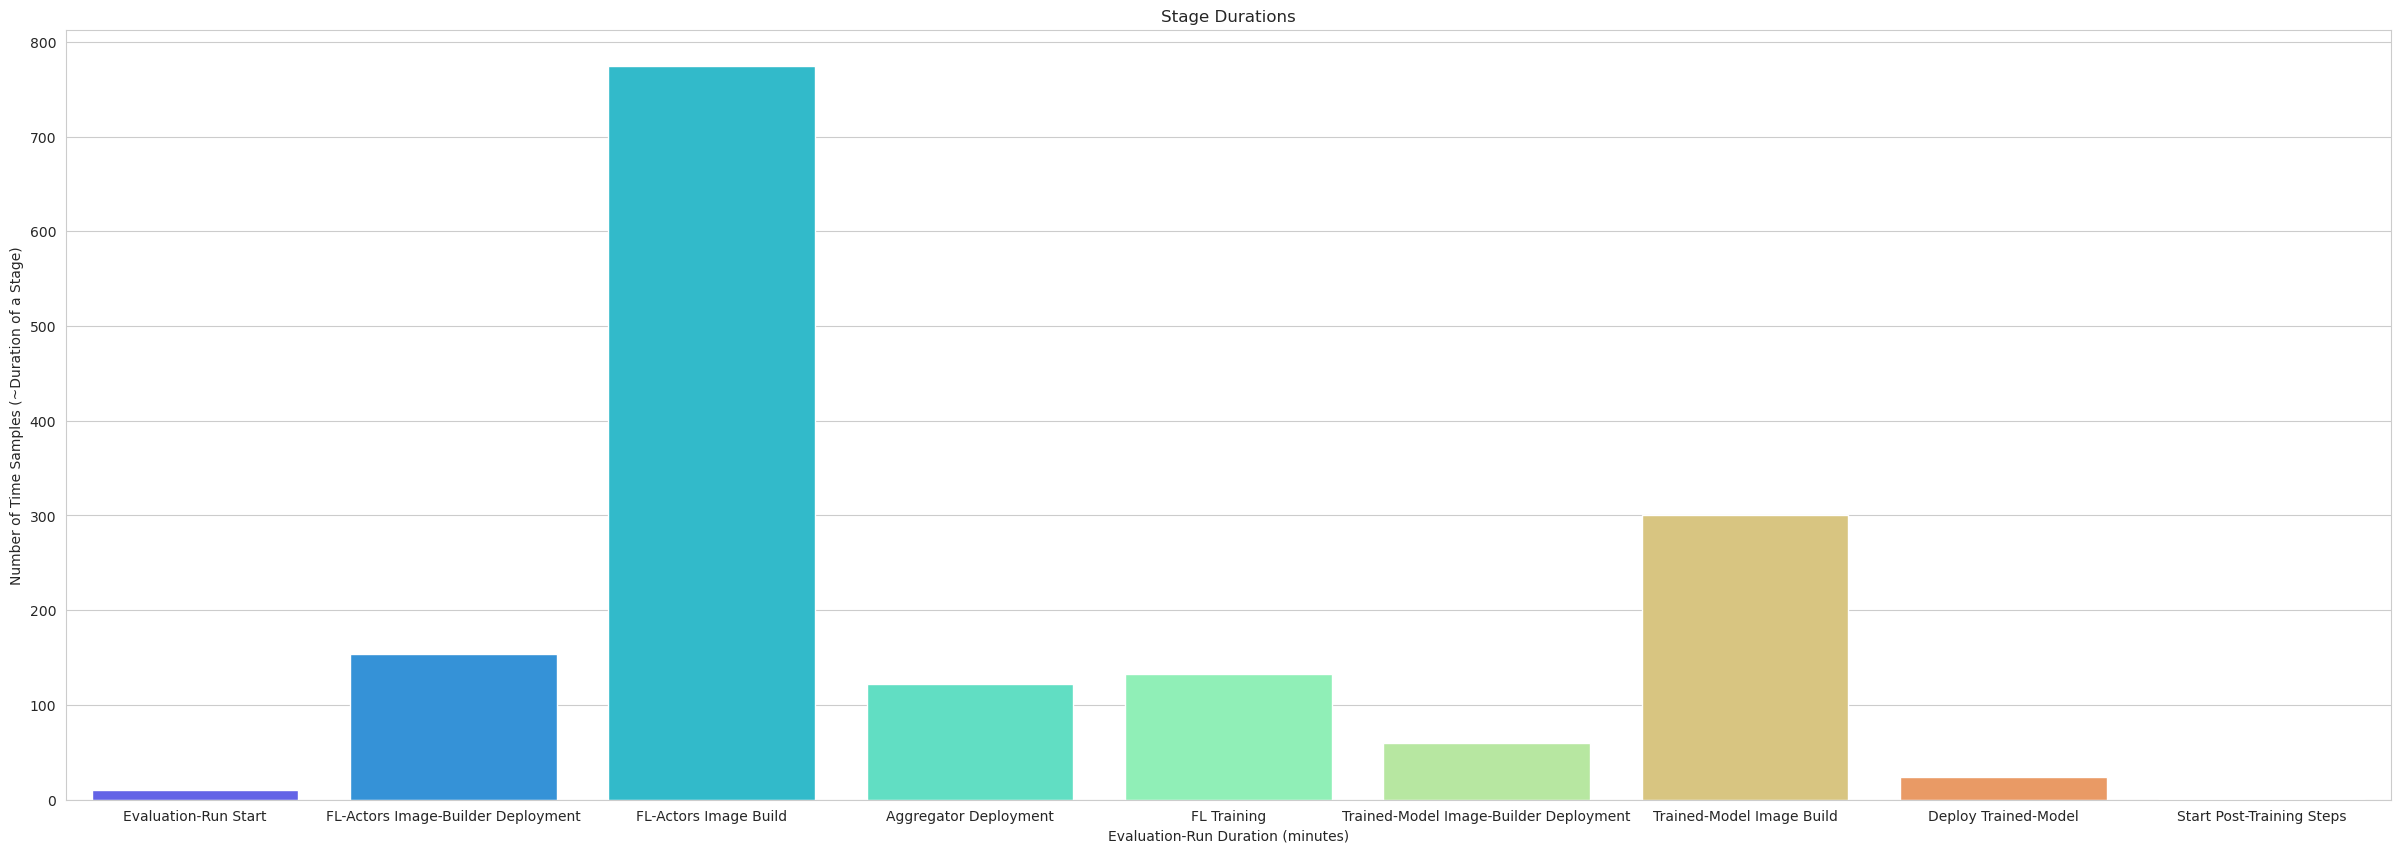

In [24]:
# Time Smaple Visualization - Stage Durations
draw_graph(
    size=(30,10),
    data=df,
    title="Stage Durations",
    plot_functions=[
        lambda: sns.countplot(
            x=STAGE_KEY,
            data=df,
            palette=flops_palette
        )
    ],
    y_label = "Number of Time Samples (~Duration of a Stage)"
)

### Disk Space Changes

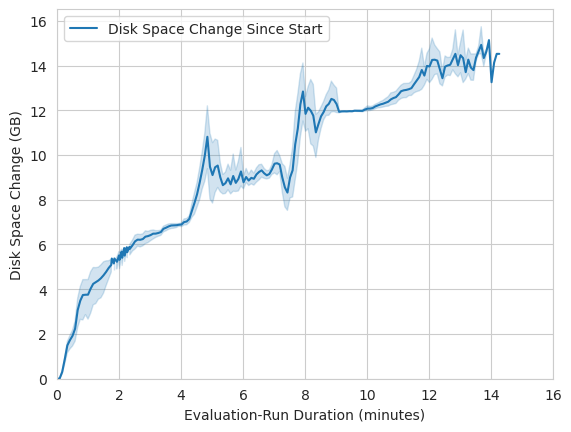

In [16]:
fig, ax = plt.subplots()

disk_space_key = DISK_START_KEY

# Note: Change MB to GB
df[[disk_space_key]] = df[[disk_space_key]] / 1024

sns.lineplot(data=df[[disk_space_key]])
#sns.lineplot(data=df, x=ResourcesCSVKeys.TIME_SINCE_START.value, y=disk_space_key, hue=ResourcesCSVKeys.EVALUATION_RUN_ID.value)

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Disk Space Change (GB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

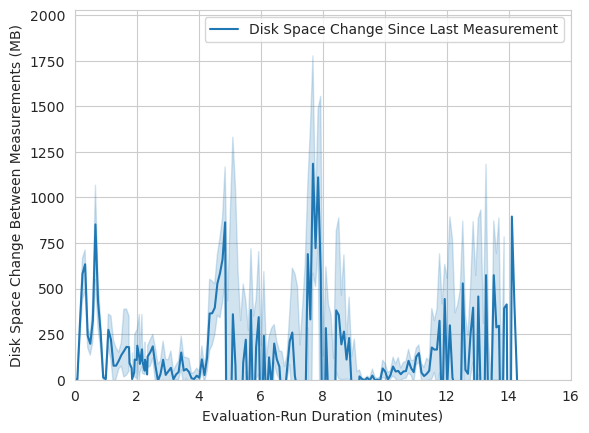

In [17]:
fig, ax = plt.subplots()

disk_space_key = ResourcesCSVKeys.DISK_SPACE_CHANGE_SINCE_LAST_MEASUREMENT.value

# Note: Change MB to GB
df[[disk_space_key]] = df[[disk_space_key]]

sns.lineplot(data=df[[disk_space_key]])

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Disk Space Change Between Measurements (MB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

### Network

### Since Start

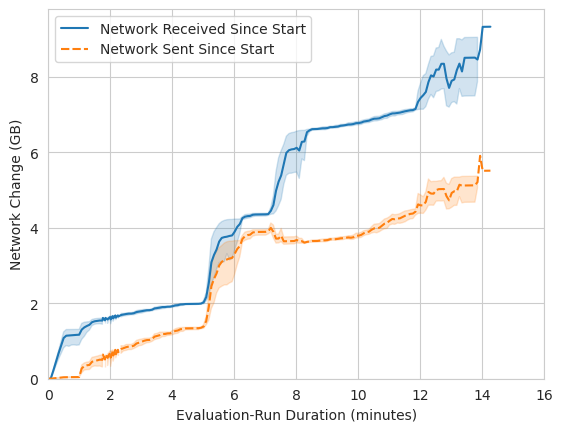

In [18]:
fig, ax = plt.subplots()

NETWORK_COMPARED_TO_START_KEYS = [ResourcesCSVKeys.NETWORK_RECEIVED_SINCE_START.value, ResourcesCSVKeys.NETWORK_SENT_SINCE_START.value]

sns.lineplot(data=df[NETWORK_COMPARED_TO_START_KEYS] / 1024)

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Network Change (GB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

### Network compared: current vs last

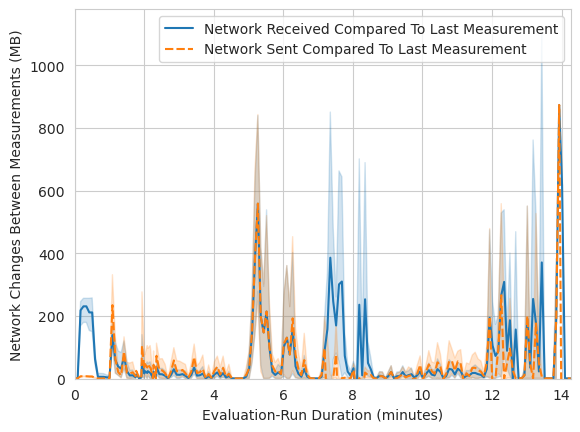

In [19]:
NETWORK_COMPARED_TO_LAST_MEASUREMENT_KEYS = [ResourcesCSVKeys.NETWORK_RECEIVED_COMPARED_TO_LAST_MEASUREMENT.value, ResourcesCSVKeys.NETWORK_SENT_COMPARED_TO_LAST_MEASUREMENT.value]

sns.lineplot(data=df[NETWORK_COMPARED_TO_LAST_MEASUREMENT_KEYS])
plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Network Changes Between Measurements (MB)")

# Constrain axes e.g. start at 0
plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

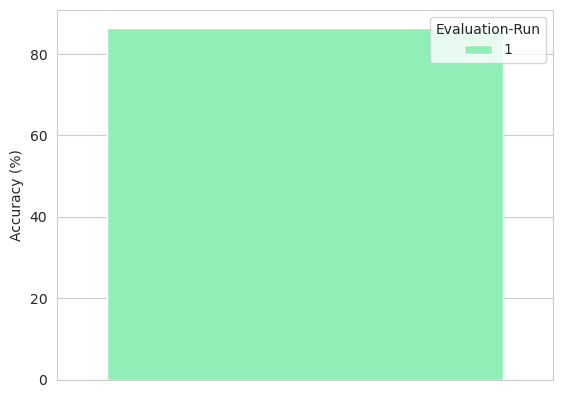

In [20]:
accuracy_key = FLOpsTrainedModelCSVKeys.ACCURACY.value
trained_model_df[accuracy_key] = trained_model_df[accuracy_key] * 100
sns.barplot(y=accuracy_key,  data=trained_model_df, palette=flops_palette, hue=FLOpsTrainedModelCSVKeys.EVALUATION_RUN.value)

plt.ylabel("Accuracy (%)")
plt.show()

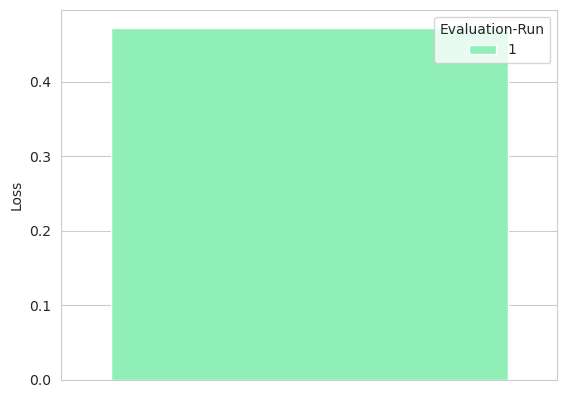

In [21]:

sns.barplot(y=FLOpsTrainedModelCSVKeys.LOSS.value,  data=trained_model_df, palette=flops_palette, hue=FLOpsTrainedModelCSVKeys.EVALUATION_RUN.value)
plt.show()

---

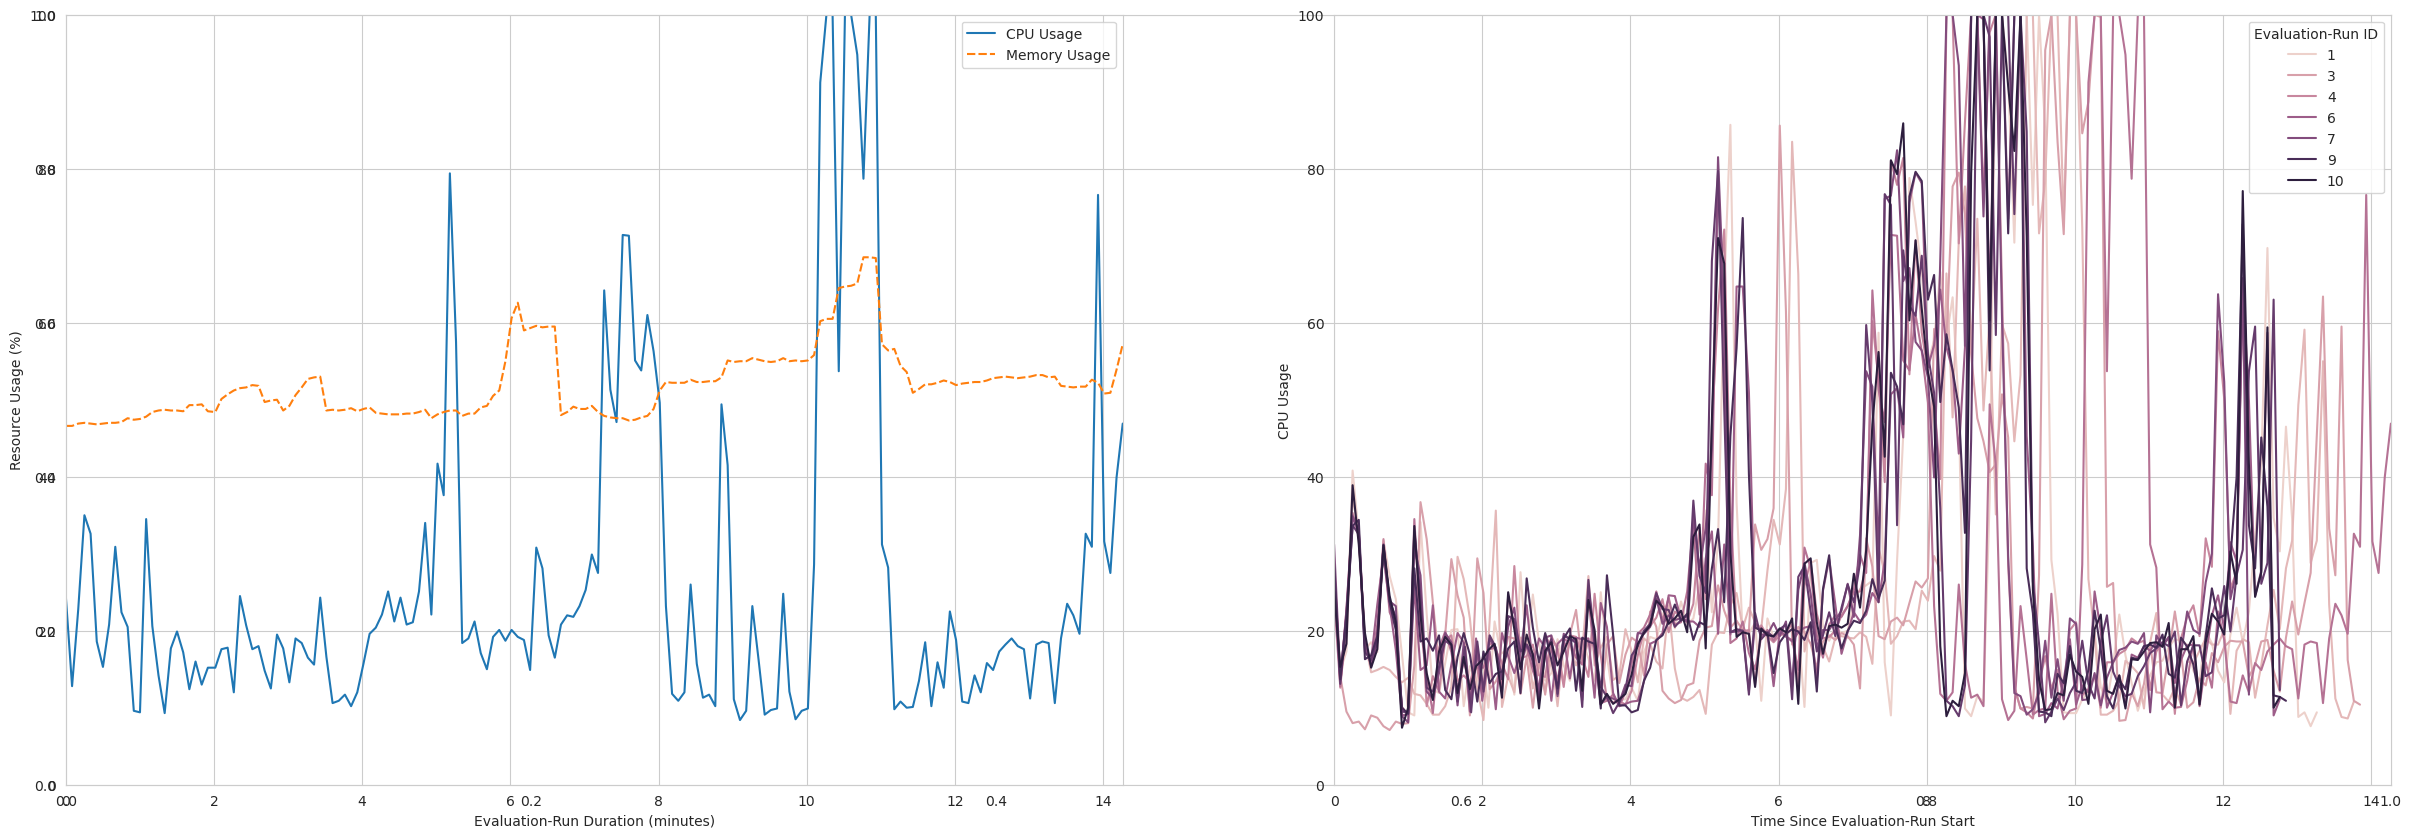

In [22]:
fig, ax = plt.subplots(figsize=(30, 10))

#df = df[df[ResourcesCSVKeys.EVALUATION_RUN_ID.value] == 3] 
plt.subplot(1,2,1)
sns.lineplot(data=singular_run_df[[CPU_KEY, MEMORY_KEY]])
#sns.lineplot(data=df[[CPU_KEY, MEMORY_KEY]])
plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Resource Usage (%)")
#adjust_xticks(ax)
plt.xlim([0, max(df.index)])
plt.ylim(0, 100)


plt.subplot(1,2,2)
sns.lineplot(data=df, x=TIME_START_KEY, y=CPU_KEY, hue=RUN_ID_KEY)
plt.xlim([0, max(df.index)])
plt.ylim(0, 100)

plt.show()

In [23]:
#sns.color_palette(palette=flops_palette, n_colors=4)
#sns.color_palette(palette="hsv", n_colors=4)
sns.color_palette(palette="tab10", n_colors=4)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]